In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/My Drive

/content/drive/My Drive


### Import Data

In [ ]:
# import packages
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
nltk.download('punkt')
import plotly.express as px
from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Data

In [ ]:
df = pd.read_csv('cms_all_2567_2019.csv',encoding='latin1')
unstructured = pd.read_csv('unstructured.csv',encoding='latin1')
#unstructured = unstructured['facility_id']
label = pd.read_csv('label.csv')
central_data = pd.read_excel('central_data.xlsx')

In [ ]:
df.head(3)

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text,inspection_year
0,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/03/2019,658,D,1,0,FCLY11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019
1,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/11/2019,550,D,1,1,8J2811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019
2,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/11/2019,607,D,1,1,8J2811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019


In [ ]:
unstructured.head(3)

0    075011
1    075013
2    075017
Name: facility_id, dtype: object

In [ ]:
label.head(3)

,Unnamed: 0,Federal Provider Number,avg_weekly_covid19_death_per_occupied_bed_pct_aggregate_max_final,High Risk,Low Risk
0,0,015009,0.163666,1,0
1,1,015010,0.000000,0,1
2,2,015012,0.000000,0,1


In [ ]:
label['label'] = label['High Risk'] - label['Low Risk']
label['label'] = label['label'].apply(lambda x: 0 if x < 0 else x)
label = label[['Federal Provider Number','avg_weekly_covid19_death_per_occupied_bed_pct_aggregate_max_final','label']]

In [ ]:
print('The size of the inspection text report is {}.'.format(len(df)))
print('There are {} unique nursing houses.'.format(len(unstructured)))
print('The size of the label dataset is {}.'.format(len(label)))

The size of the inspection text report is 124145.
There are 13678 unique nursing houses.
The size of the label dataset is 13647.


### Merge data

In [ ]:
merged = pd.merge(unstructured, label, how='inner',  left_on='facility_id', right_on='Federal Provider Number')
merged = merged.drop('Federal Provider Number',axis = 1)
merged.head(3)

,facility_id,avg_weekly_covid19_death_per_occupied_bed_pct_aggregate_max_final,label
0,075011,0.308702,1
1,075013,0.199780,1
2,075017,0.441732,1


In [ ]:
x = pd.merge( df, merged, how='inner', on='facility_id')
x.head(3)

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text,inspection_year,avg_weekly_covid19_death_per_occupied_bed_pct_aggregate_max_final,label
0,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/03/2019,658,D,1,0,FCLY11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019,0.308702,1
1,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/11/2019,550,D,1,1,8J2811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019,0.308702,1
2,"WINDSOR HEALTH AND REHABILITATION CENTER, LLC",075011,581 POQUONOCK AVE,WINDSOR,CT,6095,07/11/2019,607,D,1,1,8J2811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...,2019,0.308702,1


In [ ]:
print('The size of the merged dataset is {}.'.format(len(x)))

The size of the merged dataset is 111797.


### Data Visualization

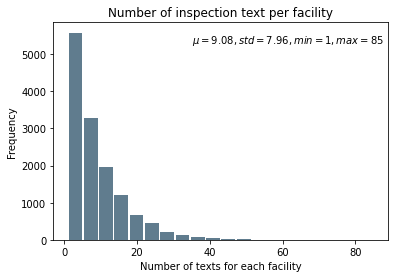

In [ ]:
# Distribution of inspection text for each nursing home
size, scale = 100, 100


unstructured['total_YN'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Number of inspection text per facility')
plt.xlabel('Number of texts for each facility')
plt.ylabel('Frequency')
plt.text(35,5300,r'$\mu=9.08, std=7.96, min = 1, max = 85$')
plt.grid()
plt.show()

In [ ]:
unstructured['total_YN'].describe()

count    13678.000000
mean         9.076181
std          7.963820
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         85.000000
Name: total_YN, dtype: float64

In [ ]:
avg = unstructured['total_severity']/unstructured['total_YN']
avg.describe()

count    13678.000000
mean         6.739702
std          5.145379
min          0.000000
25%          4.000000
50%          5.600000
75%          7.500000
max        150.000000
dtype: float64

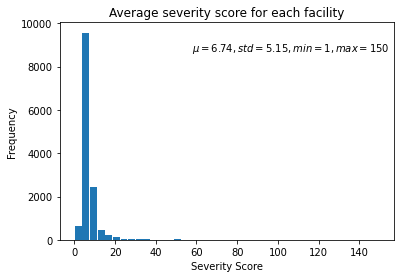

In [ ]:
# Distribution of average severity score for each nursing home
size, scale = 80, 10

avg .plot.hist(grid=True, bins=40, rwidth=0.9)
plt.title('Average severity score for each facility')
plt.xlabel('Severity Score')
plt.ylabel('Frequency')
plt.text(58,8700,r'$\mu=6.74, std=5.15, min = 1, max = 150$')
plt.grid()

Deficiency Category

In [ ]:
# Nine categories
deficiency_tag_dict = {'Resident Rights Deficiencies':set(),
                      'Freedom from Abuse, Neglect, and Exploitation Deficiencies':set(),
                      'Resident Assessment and Care Planning Deficiencies':set(),
                      'Quality of Life and Care Deficiencies':set(),
                      'Nursing and Physician Services Deficiencies':set(),
                      'Pharmacy Service Deficiencies':set(),
                      'Administration Deficiencies':set(),
                      'Nutrition and Dietary Deficiencies':set(),
                      'Environmental Deficiencies':set()
}

In [ ]:
deficiency_acron_dict = {'Resident Rights Deficiencies':'Rights',
                      'Freedom from Abuse, Neglect, and Exploitation Deficiencies':'AbuseNeglect',
                      'Resident Assessment and Care Planning Deficiencies':'CarePlanning',
                      'Quality of Life and Care Deficiencies':'LifeQuality',
                      'Nursing and Physician Services Deficiencies':'Nursing',
                      'Pharmacy Service Deficiencies':'Pharmacy',
                      'Administration Deficiencies':'Administration',
                      'Nutrition and Dietary Deficiencies':'Nutrition',
                      'Environmental Deficiencies':'Environment'}

In [ ]:
tag_to_category = {}
deficiency_tag = df['deficiency_tag'].unique().tolist()
tagnumber = central_data['Deficiency Tag Number'].tolist()
for tag in deficiency_tag:
  if tag in tagnumber:
    category = central_data[central_data['Deficiency Tag Number'] == tag]['Deficiency Category'].tolist()    
    deficiency_tag_dict[category[0]].add(tag)

In [ ]:
# match each sub-category to the parent category
df['category'] = None
for i in range(len(df)):
  for k in deficiency_tag_dict.keys():
    num = df['deficiency_tag'].iloc[i]  
    if num in deficiency_tag_dict[k]:
      df['category'].iloc[i]  = deficiency_acron_dict[k]

In [ ]:
# Retrieve the top 10 nursing homes which receive most complains
top = unstructured.sort_values(by = ['total_YN'], ascending=False)[:10][['facility_id','total_YN']]
top = top['facility_id'].tolist()
top = df[df['facility_id'].isin(top)][['facility_id', 'facility_name','category']]


In [ ]:
top

,facility_id,facility_name,category
9251,505272,LIFE CARE CENTER OF MOUNT VERNON,Rights
9252,505272,LIFE CARE CENTER OF MOUNT VERNON,Rights
9253,505272,LIFE CARE CENTER OF MOUNT VERNON,Rights
9254,505272,LIFE CARE CENTER OF MOUNT VERNON,Rights
9255,505272,LIFE CARE CENTER OF MOUNT VERNON,Rights
...,...,...,...
119947,555339,MANORCARE HEALTH SERVICES-PALM DESERT,LifeQuality
119948,555339,MANORCARE HEALTH SERVICES-PALM DESERT,Nutrition
119949,555339,MANORCARE HEALTH SERVICES-PALM DESERT,Nutrition
119950,555339,MANORCARE HEALTH SERVICES-PALM DESERT,Environment


In [ ]:
# The proportion of each deficiency category among top 10 nursing homes
fig = px.bar(top, x='category', y='facility_name', template='plotly_white', orientation='h',
             labels={'category': 'Complaints', 'facility_name': 'Facility'},
             color='category', color_discrete_sequence=px.colors.qualitative.Safe)
fig.update_layout(font=dict(size=10, color='DarkSlateGray'))
fig.update_layout(width=1200, height=500)
fig.show()

In [ ]:
x.isna().sum()

facility_name                                                        0
facility_id                                                          0
address                                                              0
city                                                                 0
state                                                                0
zip                                                                  0
inspection_date                                                      0
deficiency_tag                                                       0
scope_severity                                                       0
complaint                                                            0
standard                                                             0
eventid                                                              0
inspection_text                                                      0
inspection_year                                                      0
avg_we

Text processing

In [ ]:
def remove_html_tags(text):
    text = text.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return text

In [ ]:
def remove_pre_sentence(text):
  text = text.apply(lambda x: x.split('** ')[1] if x.startswith("**") else x)
  text = text.apply(lambda x: x[1:] if x.startswith(">") else x)  
  return text

In [ ]:
def remove_symbol(text):
  res = ''
  text = text.split(' ')
  for word in text:
    word = re.sub('[@#$/?:;()\'\[\]-]', '', word)
    if word != '':
      res += word
      res += ' '
  return res.strip()

In [ ]:
def clean_text(text):   
    text = remove_html_tags(text)
    text = remove_pre_sentence(text)
    #text = nltk.sent_tokenize(text)
    text = text.apply(lambda x: remove_symbol(x))
    text = text.apply(lambda x: x.lower())
    #text = text.apply(lambda x:convert_number(x))  do we need to contain number info?
    return text

In [ ]:
#pip install sumy
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

LANGUAGE = "english"
SENTENCES_COUNT = 3

In [ ]:
def summery(text):
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    stemmer = Stemmer(LANGUAGE)
    summarizer = Summarizer(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)
    result = ""
    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        result += str(sentence)
    if result == '':
        text = text.replace(' ','')
        text = text.replace('\t','')
        return text
    else:
        return result

In [ ]:
x['inspection_text'] = clean_text(x['inspection_text'])

In [ ]:
lemma_english_stopwords = [WordNetLemmatizer().lemmatize(word) for word in stopwords.words('english')]
stop_words = lemma_english_stopwords + ['pm', 'am','cm','a', 's','and/or','','and','also','c','at','the','as','na']
def lemmatize_words(words, stop_words):
  res = ''
  lemmatizer = WordNetLemmatizer()
  for word in words.split(' '):
    if word == '':
      continue
    if word in stop_words:
      continue
    res += lemmatizer.lemmatize(word, 'v')
    res +=' '
  return res.strip()

In [ ]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
  wc = WordCloud(width=800, height=400,background_color= "black", colormap="Paired",max_font_size=150, max_words=max_words)
  # convert data frame into dict
  if type(word_freq) == pd.Series:
    counter = Counter(word_freq.fillna(0).to_dict())
  else:
    counter = word_freq
  # filter stop words in frequency counter
  if stopwords is not None:
    counter = {token:freq for (token, freq) in counter.items() if token not in stopwords} 
  wc.generate_from_frequencies(counter)
  plt.title(title)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

Top words

In [ ]:
# choose one inspection text as an example
text = lemmatize_words(x['inspection_text'][24], stop_words)

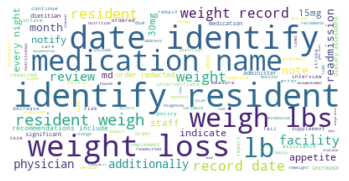

In [ ]:
from wordcloud import WordCloud as WordCloud
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()